In [ ]:
# Package Load
import pickle
import pyLDAvis
import math
import copy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import tomotopy.coherence as tpc
from gensim.corpora import Dictionary
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
from timeit import default_timer
import plotly.express as px
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
version_name=str(datetime.today().strftime("%Y%m%d")) # 버전 정보 변수
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import matplotlib.font_manager as fm
import matplotlib as mpl

In [3]:
import networkx as nx
import operator
import scipy
import itertools
#pip install scipy networkx==2.6.3  # coo_array에러나면 실행

In [4]:
os.chdir("C:\\Users\\newcomer02\\NTIS_Project")

# 기존에 학습된 모델 불러오기 

In [5]:
# input : model 폴더명, 해당 폴더, 없으면 오류 발생 (원하는 버전 모델 있으면 지정, 없으면 Enter -> Default)
# model 폴더 안에 bin, npy 파일 필요, 없으면 오류 발생

lda_ver=input("불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) : ")
topic_num = int(input("모델의 토픽 수를 입력하세요. (※ 권장값 = 180개)"))
if lda_ver=='':
    print("\nDefault LDA모델을 불러옵니다.")
    mdl=tp.LDAModel.load("./model/LDA_MODEL_20.bin")
#    lda_info =np.load("./data/LDA/Default/ict_index.npy")
else:
    print("\n%s 에 학습된 LDA모델을 불러옵니다."%(lda_ver[-8:]))
    mdl=tp.LDAModel.load("./model/"+lda_ver+"/LDA_MODEL_"+str(topic_num)+".bin")
#    lda_info =np.load("./data/LDA/"+lda_ver+"/ict_index.npy")

불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) :  
모델의 토픽 수를 입력하세요. (※ 권장값 = 180개) 20



Default LDA모델을 불러옵니다.


# 파일 불러오기 

In [6]:
folder_name=input("사용할 데이터 폴더명을 입력하세요(Default: 엔터키): ")
lda_txt="LDA_PRED_"+ folder_name
DATA_DIR = "./data/Default/"+ folder_name+ "/"
# NKIS, NTIS, REPORT, GOV
print(DATA_DIR + lda_txt)

사용할 데이터 폴더명을 입력하세요(Default: 엔터키):  GOV


./data/Default/GOV/LDA_PRED_GOV


In [7]:
# input : data/LDA 폴더에 txt 형태 코퍼스 파일, 없으면 오류 발생

corpus=[]
for n, line in tqdm(enumerate(open(DATA_DIR+lda_txt+".txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus.append(doc)
print("코퍼스 파일 로드가 완료되었습니다.")

48it [00:00, 23927.57it/s]

코퍼스 파일 로드가 완료되었습니다.


# corpus파일 전처리

In [8]:
 ##단어 없는 것 제거
temp = []
for cnt in range(len(corpus)):
    if len(corpus[cnt])  != 0 :
        temp.append(corpus[cnt])
        
corpus = temp

In [9]:
## 불용어

from string import ascii_lowercase
from string import ascii_uppercase
alphabet_list = list(ascii_lowercase) + list(ascii_uppercase)
alphabet_list.append("ㆍ")
#+ list(topic2["0"])
#print(len(topic2["0"]))
# 52부터 topic2 51까지 알파벳 대소문자 
#alphabet_list = alphabet_list[:550] #숫자만 바꿔주면됨 
len(alphabet_list)

53

In [10]:
unusing_dic = pd.DataFrame()
unusing_dic["term"] = alphabet_list

In [11]:
temp_f =[]
remove_set =unusing_dic["term"].tolist()

for temp_1 in tqdm(corpus) :
    temp_t = [temp_2 for temp_2 in temp_1 if temp_2 not in remove_set]
    temp_f.append(temp_t)
    
corpus = temp_f

100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 7999.31it/s]


# 모델 밖의 문헌 생성 후 추론하기

In [12]:
doc_insts = []
for i in range(len(corpus)) :
        doc_insts.append(mdl.make_doc(corpus[i]))
topic_dist, ll = mdl.infer([doc_insts][0])

# 년도별 토픽 분포 그래프 

In [88]:
#cc = pd.read_pickle("./data/Default/"+ folder_name + "/HAN_Filtered_" + folder_name+ ".pkl")
#cc =cc[cc["filtered_ICT"]==1][["year"]].reset_index(drop=True)
#cc.to_csv("./data/Default/"+ folder_name + "/HAN_year_" +folder_name+ ".csv")

In [161]:
if folder_name == "GOV":
    df = pd.read_pickle("./data/Default/"+ folder_name + "/HAN_Filtered_" + folder_name+ ".pkl")
    df = df[df["filtered_ICT"]==1]
    df["year"] = 2023
    df = pd.DataFrame(df["year"]).reset_index(drop=True)
else:
    df = pd.read_csv("./data/Default/"+folder_name+"/HAN_year_" + folder_name+ ".csv",index_col=0)
    df = pd.DataFrame(df["year"].replace(2022,2021)) 

## 2022년 데이터 2021데이터로 변경 

In [162]:
df.value_counts()

year
2023    48
dtype: int64

In [163]:
year_range= int(input("몇개년 데이터인지 입력하시오 ex)5개년:5, 1개년:1 :"))
start_num = int(input("시작년도를 입력하시오:"))
end_num = int(input("마지막년도를 입력하시오:"))

몇개년 데이터인지 입력하시오 ex)5개년:5, 1개년:1 : 1
시작년도를 입력하시오: 2023
마지막년도를 입력하시오: 2023


In [164]:
year_list = []
for i in range(year_range):
    globals()["year_{}".format(str(i+start_num))] = []
for i in range(year_range):
    year_list.append(globals()["year_{}".format(str(i+start_num))])

In [165]:
j = 0
for i in range(start_num,(end_num+1)):
    year_list[j] = df[df==i].dropna().index.tolist()
    j +=1 

In [166]:
idx_list = []
for i in range(year_range):
    globals()["year_{}".format(str(i+start_num))] = []
for i in range(year_range):
    idx_list.append(globals()["year_{}".format(str(i+start_num))])
for i in range(len(year_list)):
    for j in year_list[i]:
        idx_list[i].append(topic_dist[j])

In [167]:
df_list = [] 
for i in range(year_range):
    globals()["year_{}".format(str(i+start_num))] = pd.DataFrame()
for i in range(year_range):
    df_list.append(globals()["year_{}".format(str(i+start_num))])
for i in range(year_range):
    for j in range(len(idx_list[i])):
        df_list[i] = pd.concat([df_list[i], pd.DataFrame(idx_list[i][j])],axis=1)

In [168]:
total_dist = pd.DataFrame()
for i in range(year_range):
    total_dist=pd.concat([total_dist,pd.DataFrame(df_list[i].sum(axis=1))],axis=1)
total_dist.columns = [i for i in range(start_num,end_num+1)]

In [169]:
dist=total_dist/np.array(total_dist.sum())

In [170]:
dist

,2023
0,0.000039
1,0.000568
2,0.005089
3,0.020810
4,0.033598
5,0.486208
6,0.049721
7,0.001856
8,0.040492
9,0.009086


In [171]:
#검산
dist.sum(axis=0) # 컬럼 별 1이 나오면 됨

2023    1.0
dtype: float32

In [172]:
topics_d = []
for i in range(mdl.k):
    topic_d = str("topic_") + str(i+1)
    topics_d.append(topic_d)

## 5개년 합산 평균 분포 그래프 

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



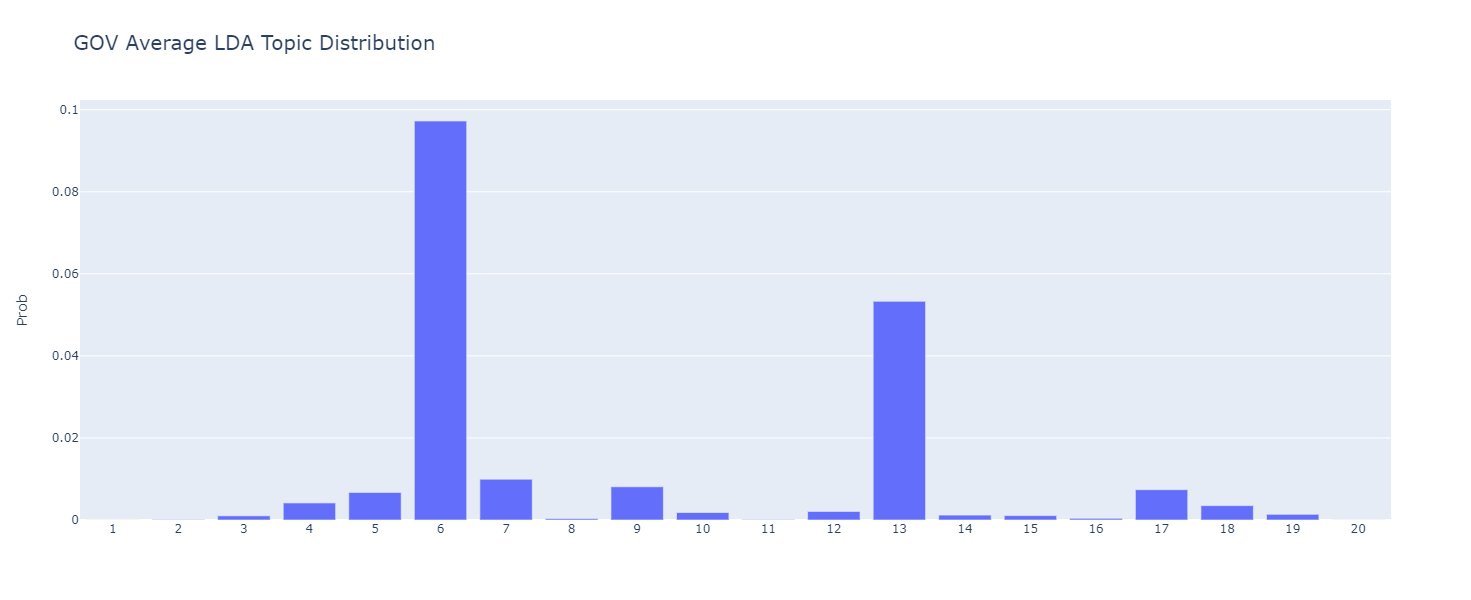

In [173]:
dist_one = pd.DataFrame(dist.sum(axis=1)/5)
for i in dist_one.columns.tolist():
    # output type : Average ICT NTIS/NEWS 연도별 html 파일 (html/DTM 폴더)

    fig = make_subplots(
            rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1
        )
    fig.add_bar(x=[str(i+1) for i in range(len(topics_d))], y=dist_one[i], name ="REPORT", row=1, col=1)
    fig.update_layout(title=go.layout.Title(text=folder_name+ " Average LDA Topic Distribution",
                                            font=go.layout.title.Font(size=20)),
                     yaxis_title="Prob",height=600)

    fig.update_xaxes(visible=True, showticklabels=True)
    fig.update_yaxes(visible=True, showticklabels=True)
    fig.show()
    #fig.write_html('./html/DTM/Average_DTM'+str(num_topics)+'.html')
    #fig.write_html('./html/DTM/Average_DTM'+str(23)+'.html')

## 5개년 년도 별 분포 그래프

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



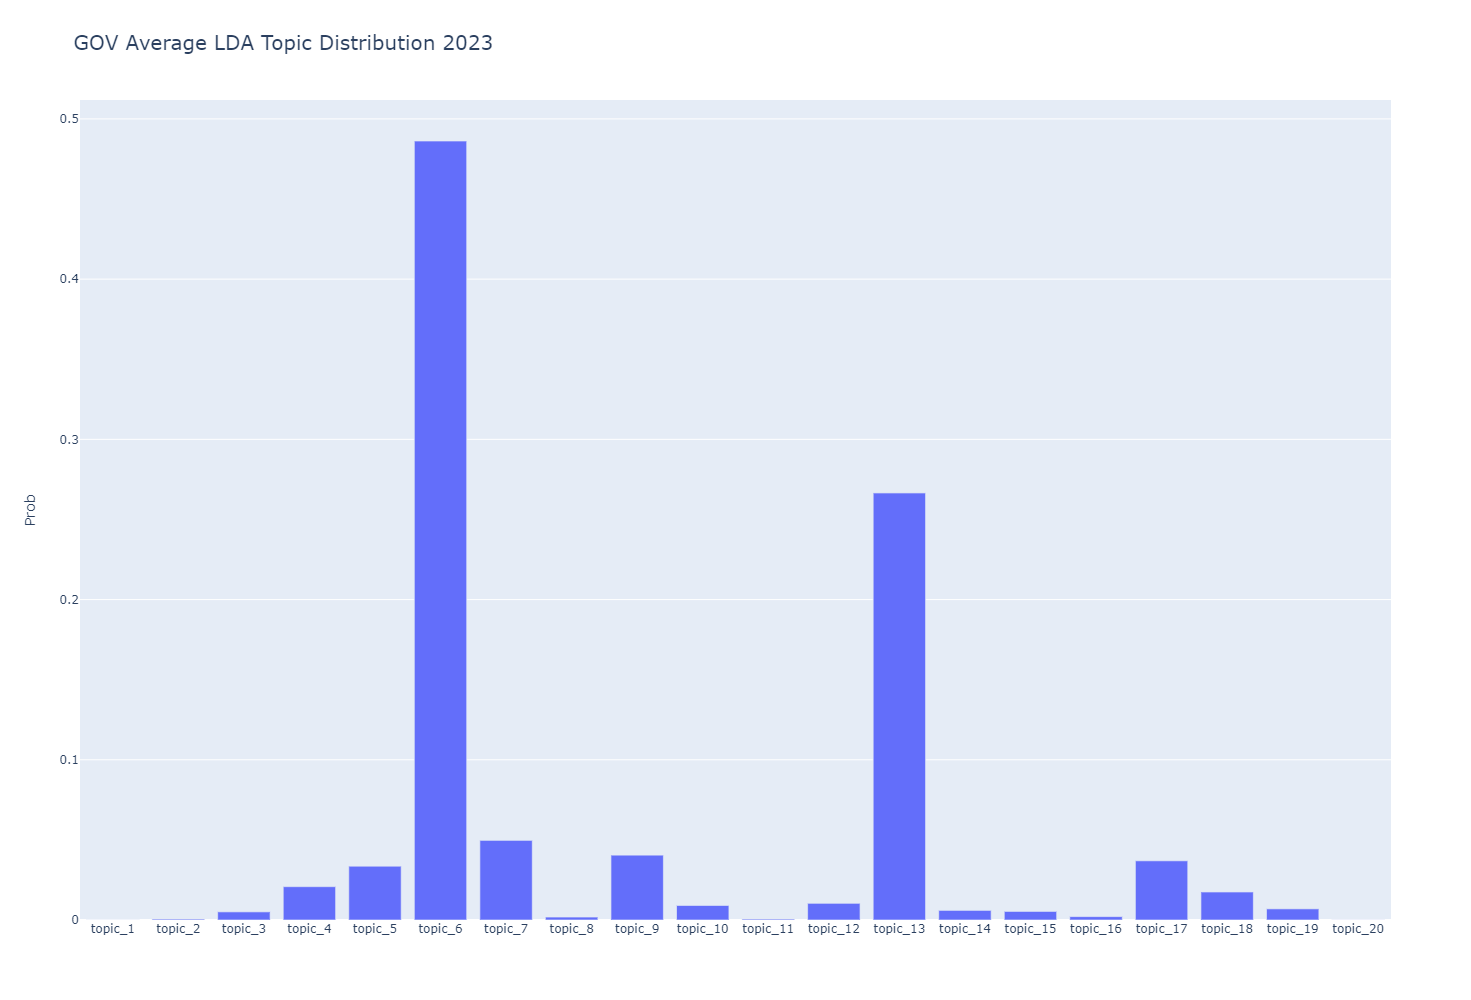

In [175]:
for i in dist.columns.tolist():
    # output type : Average ICT NTIS/NEWS 연도별 html 파일 (html/DTM 폴더)

    fig = make_subplots(
            rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1
        )
    fig.add_bar(x=topics_d, y=dist[i], name ="NKIS", row=1, col=1)
    fig.update_layout(title=go.layout.Title(text=folder_name+" Average LDA Topic Distribution "+ str(i) ,
                                            font=go.layout.title.Font(size=20)),
                     yaxis_title="Prob",height=1000)

    fig.update_xaxes(visible=True, showticklabels=True)
    fig.update_yaxes(visible=True, showticklabels=True)
    fig.show()
    #fig.write_html('./html/DTM/Average_DTM'+str(num_topics)+'.html')
    #fig.write_html('./html/DTM/Average_DTM'+str(23)+'.html')

# 5개년 상위 토픽별 꺾은선 그래프 

In [138]:
topn = pd.DataFrame(dist.sum(axis=1)).reset_index()
topn.set_index(["index"],inplace=True)
topn.sort_values(0,inplace=True,ascending=False)

In [139]:
color=[ 'aquamarine', 'black', 'blue',
            'blueviolet', 'brown', 'burlywood', 'cadetblue',
            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
            'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray', 'dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen',
            'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan',
            'lightgoldenrodyellow', 'lightgray', 'lightgrey',
            'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen',
            'lightskyblue', 'lightslategray', 'lightslategrey',
            'lightsteelblue', 'lightyellow', 'lime', 'limegreen',
   #         linen, magenta, maroon, mediumaquamarine,
   #         mediumblue, mediumorchid, mediumpurple,
   ##         mediumseagreen, mediumslateblue, mediumspringgreen,
   #         mediumturquoise, mediumvioletred, midnightblue,
   #         mintcream, mistyrose, moccasin, navajowhite, navy,
   #         oldlace, olive, olivedrab, orange, orangered,
   #         orchid, palegoldenrod, palegreen, paleturquoise,
   #         palevioletred, papayawhip, peachpuff, peru, pink,
   #         plum, powderblue, purple, red, rosybrown,
   #         royalblue, rebeccapurple, saddlebrown, salmon,
   #         sandybrown, seagreen, seashell, sienna, silver,
   #         skyblue, slateblue, slategray, slategrey, snow,
    #        springgreen, steelblue, tan, teal, thistle, tomato,
    #        turquoise, violet, wheat, white, whitesmoke,
            'yellow', 'yellowgreen']

In [140]:
zz = topn[:int(input("상위 토픽개수를 정해주시오:"))].index.tolist()

상위 토픽개수를 정해주시오: 20


In [182]:
# zz = topn[6:].index.tolist() 
# dist = dist.drop([22,24,40,30,39,11])
# print(len(zz),len(dist))

In [ ]:
    total_ntis = []
    for i in zz:
        trace = go.Scatter(y = dist.iloc[i], mode = 'lines+markers',
                            hovertext='NKIS '+ str(i+1), 
                           hoverinfo='text',
                           name = 'NKIS_Topic '+ str(i+1),
                           marker=dict(symbol='cross', color=color[i]),
                          )
        total_ntis.append(trace)

    
    layout = go.Layout(title=folder_name + ' LDA 상위 '+str(len(zz))+'개 토픽별 트렌드',legend=dict(font=dict(size=15)),margin=dict(l=20, r=20, t=60, b=100),paper_bgcolor="White",
                       autosize=True,title_font_size=20,font=dict(size=15),hoverlabel=dict(
        
        font_size=16,
        font_family="Rockwell"
    ),
                    xaxis=dict({"tickvals":[0,1,2,3,4],
                            "ticktext":dist.columns[:5].tolist(),
                           "title":"Year"}),
                    yaxis=dict({"title":"Prob"}),
                    height=500,width=500)
    
    gen_ntis = go.Figure(data=total_ntis, layout=layout)
    pyo.iplot(gen_ntis)

# 년도에 따른 토픽 별 대표문서 보기

In [73]:
doc_list = []
for i in range(int(year_range)):
    globals()["year_{}".format(str(i+2017))] = []
for i in range(int(year_range)):
    doc_list.append(globals()["year_{}".format(str(i+2017))])
    for j in range(mdl.k):
        globals()["topic_{}".format(str(j+1))] = pd.DataFrame(columns=["index","prob"])
    for j in range(mdl.k):
        doc_list[i].append(globals()["topic_{}".format(str(j+1))])

In [74]:
for i in tqdm(range(len(year_list))):
    for j in year_list[i]:
        #if mdl.docs[j].get_topics()[0][1] > 0.5:
            doc_list[i][doc_insts[j].get_topics()[0][0]] =\
            pd.concat([doc_list[i][doc_insts[j].get_topics()[0][0]],
                   pd.DataFrame([(j,doc_insts[j].get_topics()[0][1])],columns=["index","prob"])])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.03it/s]


In [75]:
for i in tqdm(range(len(doc_list))):
    for j in range(len(doc_list[i])):
        doc_list[i][j] = doc_list[i][j].sort_values("prob",ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.13it/s]


In [76]:
tt  = int(input("상위 몇개 토픽을 볼 것인지 입력하시오:"))

상위 몇개 토픽을 볼 것인지 입력하시오: 3


In [ ]:
for i in tqdm(range(mdl.k)) : 
    print("\n\n\n topic_" + str(i+1))
    for u in range(len(doc_list)):
        print("\n\nYear_"+str(u+2017))
        for j in range(tt):
            try:    
                print("\nindex : " + str(doc_list[u][i]["index"].iloc[:j+1].tolist()[j]))
                print("prob : " + str(doc_list[u][i]["prob"].iloc[:j+1].tolist()[j]))
                print(doc_insts[doc_list[u][i]["index"].iloc[:j+1].tolist()[j]])
            except IndexError:
                print("\n해당 토픽과 년도에 존재하는 문서가 없음")


In [78]:
cc = pd.read_pickle("./data/Default/"+ folder_name + "/HAN_Filtered_" + folder_name+ ".pkl")
cc =cc[cc["filtered_ICT"]==1].reset_index(drop=True)

In [82]:
a = cc.iloc[33,:]["contents"].replace("\r","")
b = a.replace("\n","")
b.replace("tag","")

'초광대역  초고신뢰성 저지연  대규모 기기간통신으로 대변되는 5G 이동통신 서비스 구현을 위해 고밀집 스몰셀의 활용이 증가할 것으로 예상되고 있으며 이어 따른 전송망 수요도 증가할 것으로 전망된다  전송망은 대용량 전송이 필요해 주로 광케이블이 이용되고 있으나 스몰셀 밀집도 증가에 따라 경제적이고 용이한 설치가 가능한 무선 전송망의 역할도 필요할 것으로 예상할 수 있으며 이를 위한 주파수 확보도 필요할 것으로 전망된다  이에 ITU 등 국제기구  미국  영국 등 주요국은 고정업무용 주파수를 활용한 전송망용 주파수 확보방안을 검토하고 있다  기존에 고정업무로 활용되고 있는 60 GHz 대역  70 80 GHz 대역의 대역폭을 확대하거나 90 GHz 대역 및 100 GHz 이상 대역의 신규 분배를 검토하고 있으며  최근 mm파 대역의 5G 이동통신용 신규 지정 시 유연한 주파수 활용을 위해 이동업무와 고정업무를 모두 허용하는 방안이 검토되고 있다  이에 국내에서도 5G 상용화 진행에 따른 트래픽 증가 추세  서비스 사업자 수요 등을 고려해 전송망용 주파수 활용을 위한 신규분배  채널폭 확대  기술기준개정  이동 고정 용도 유연화 검토가 필요하다  I   II  무선 전송망의 특징1  이동통신 시스템의 전송망 2  무선 전송망 주파수 선택을 위한 고려사항3  무선 전송망 기술발전 동향III  해외 고정업무용 주파수 확보 동향1  ITU R  2  유럽 CEPT  3  미국 FCC  4  영국  Ofcom   5  시사점 IV  결론'

In [ ]:
## 문서가 제대로 들어가있는지 확인하는 반복문
for j in range(5):
    z = 0
    for i in range(41):
        z +=len(doc_list[j][i])
    print(z)

# 년도에 따른 토픽 별 텍스트 네트워크 

In [149]:
wd_network = pd.DataFrame(index=range(len(corpus)),columns=["corpus","mdl.docs","Topic","Topic_prob"])

for i in tqdm(range(len(corpus))):
    wd_network.iloc[i][0] =  ' '.join(map(str, corpus[i]))

for j in tqdm(range(len(doc_insts))):
    wd_network.iloc[j][1] = doc_insts[j]

for z in tqdm(range(len(doc_insts))):
    wd_network.iloc[z][2] = doc_insts[z].get_topics(top_n=mdl.k)[0][0] + 1

for c in tqdm(range(len(doc_insts))):
    wd_network.iloc[c][3] = doc_insts[c].get_topics(top_n=mdl.k)[0][1]

wd_network["year"] = df["year"].astype(int).copy()
if folder_name != "GOV":
    wd_network["year"] = wd_network["year"].replace(2022,2021)
else:
    pass

100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 16016.44it/s]


In [150]:
wd_network

,corpus,mdl.docs,Topic,Topic_prob,year
0,민 관 디지털 경제 패권 국가 실현 전 세계 디지털 전환 과 기술 패권 경쟁 속 민...,"(민, 관, 디지털, 경제, 패권, 국가, 실현, 전, 세계, 디지털, 전환, 과,...",6,0.621606,2022
1,선진 재난안전 관리체계 구축 기후변화 신종 감염병 등 복잡 대 재난 에 신속 과학적...,"(선진, 재난안전, 관리체계, 구축, 기후변화, 신종, 감염병, 등, 복잡, 대, ...",13,0.964096,2022
2,콘텐츠 의 매력 영향력 지속 을 콘텐츠 의 매력 콘텐츠 의 지속가능한 발전 공정 미...,"(콘텐츠, 의, 매력, 영향력, 지속, 을, 콘텐츠, 의, 매력, 콘텐츠, 의, 지...",6,0.495383,2022
3,국민 생애 단계별 직업 능력 개발 과 일터 지원 국민 평생 요한 직업 능력 개발 기...,"(국민, 생애, 단계별, 직업, 능력, 개발, 과, 일터, 지원, 국민, 평생, 요...",6,0.674677,2022
4,글로벌 미디어 강국 실현 미디어 규제 개선 및 OTT 등 디지털미디어 콘텐츠 산업 ...,"(글로벌, 미디어, 강국, 실현, 미디어, 규제, 개선, 및, OTT, 등, 디지털...",9,0.524932,2022
5,세계 최고 의 네트워크 구축 및 디지털 5G 6G 네트워크 인프라 고도 네트워크 안...,"(세계, 최고, 의, 네트워크, 구축, 및, 디지털, 5G, 6G, 네트워크, 인프...",6,0.762918,2022
6,공공기관 이전 등 지역 성장 거점 육성 수도 완성 세종 국가균형발전 거점 육성 공공...,"(공공기관, 이전, 등, 지역, 성장, 거점, 육성, 수도, 완성, 세종, 국가균형...",6,0.998644,2022
7,코로나19 소상공인 자영업자 의 완전한 도약 온전 손실보상 경영 부담 완화 등 긴급...,"(코로나19, 소상공인, 자영업자, 의, 완전한, 도약, 온전, 손실보상, 경영, ...",7,0.531476,2022
8,국민 과 동행 디지털 미디어 세상 소외 계층 을 포함 국민 대상 미디어 접근성 및 ...,"(국민, 과, 동행, 디지털, 미디어, 세상, 소외, 계층, 을, 포함, 국민, 대...",9,0.421925,2022
9,미래 금융 디지털 금융혁신 금융 의 자의 재량 여지 축소 및 금융권 자율 성과 책임...,"(미래, 금융, 디지털, 금융혁신, 금융, 의, 자의, 재량, 여지, 축소, 및, ...",17,0.476542,2022


In [151]:
wd_network["Topic"].nunique() #존재하지 않는 토픽이 많음을 확인

7

In [152]:
wd_network_lda = wd_network.copy() ##최초 1회만 실행

In [153]:
year_range = input("사용년도의 범위를 입력하시오 ex)2017~2021:5 :")
topic_len = input("토픽의 개수를 입력하시오:")

사용년도의 범위를 입력하시오 ex)2017~2021:5 : 1
토픽의 개수를 입력하시오: 20


# 보고서 쓰기위한 워드 데이터프레임 생성

In [168]:
# from collections import Counter

# df = pd.DataFrame()
# for c in range(2017,2022):
#     wd_network = wd_network_lda[wd_network_lda["year"]==c]
#     final = []
#     for j in range(topic_num):
#         temp= []
#         temp2 = []
#         using_word = np.array(mdl.get_topic_words(j,500))[:,0].tolist()
#         wd = wd_network[wd_network["Topic"]==j+1]
#         if len(wd)>0:
#             for i in range(len(wd)):
#                 temp.append(wd["corpus"].iloc[i].split(" "))
#             temp = sum(temp,[])
#             all_word =Counter(temp).most_common()
#             for i in (np.array(all_word)[:,0].tolist()):
#                 if i in using_word:
#                     temp2.append(i)
#                     if len(temp2)==10:
#                         break
#             final.append(temp2)
#         else:
#             final.append("")
#     df = pd.concat([df,pd.Series(final)],axis=1)

# df.columns=range(2017,2022)
# df.index = df.index+1

# df.to_excel("NKIS토픽별 주요 단어.xlsx",index=False)
# df

## 자동

In [ ]:
for timepoint in tqdm(range(int(year_range))):

    if timepoint == 0:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2017]
    elif timepoint == 1:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2018]
    elif timepoint == 2:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2019]
    elif timepoint == 3:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2020]
    elif timepoint == 4:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2021]
        

    for topic_num in tqdm(range(int(topic_len))):
        using_word= []
        try:
            for i in range(500):
                using_word.append(mdl.get_topic_words(topic_num,top_n=500)[i][0]) 

            df = pd.DataFrame()
            if len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False)) < 100:
                a = len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False))
            else :
                a = 100 
            for i in range(a):
                temp = wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False).iloc[i][0]
                temp2 = []
                for j in (temp.split(" ")):
                    if j in using_word:
                        temp2.append(j)
                    else:
                        continue
                count = {}
                for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
                    for b in temp2[c+1:]:
                        if a>b:
                            count[b,a] = count.get((b,a),0)+1
                        else:
                            count[a,b] = count.get((a,b),0)+1
                word_df = pd.DataFrame.from_dict(count,orient="index")  
                df = pd.concat([df,word_df])

            df.reset_index(inplace=True)
            df[1] = pd.DataFrame(df["index"].tolist())[0]
            df[2] = pd.DataFrame(df["index"].tolist())[1]
            df = df[df[1]!=df[2]]
            df= pd.DataFrame(df.groupby("index")[0].sum())

            list1 = []
            for i in range(len(df)):
                list1.append([df.index[i][0],df.index[i][1],df[0][i]])

            df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
            df3 = df2.sort_values(by=["freq"],ascending=False)
            df3 = df3.reset_index(drop=True)

            i =1
            while len((np.where(df3["freq"]>=i))[0])>100:
                i +=1
            freq_num=i

            G_centrality = nx.Graph()
            for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
                G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))

            dgr = nx.degree_centrality(G_centrality)      #연결 중심성
            btw = nx.betweenness_centrality(G_centrality) #매개 중심성
            cls = nx.closeness_centrality(G_centrality)   #근접 중심성
            egv = nx.eigenvector_centrality(G_centrality, tol=1.0e-3) #고유벡터 중심성
            pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

            sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
            sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
            sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
            sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
            sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

            G= nx.Graph()

            for i in range(len(sorted_pgr)):
                G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])
            for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
                G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])

            sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

            ## 마이너스 폰트 깨지는 문제에 대한 대처
            mpl.rcParams['axes.unicode_minus'] = False
            font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
            fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

            options={
                "edge_color":'#FFDEA2',
                "width":1,
                "with_labels":True,
                "font_weight":"bold",
            }

            plt.figure(figsize=(16,8)); 
            nx.draw_networkx(G,node_size=sizes,pos=nx.kamada_kawai_layout(G),**options,font_family=fontprop)
            ax = plt.gca()
            ax.collections[0].set_edgecolor("#555555")

            plt.savefig("C:\\Users\\newcomer02\\NTIS_Project\\data\\Default\\NTIS\\LDA\\Topic_Network_NKIS\\Topic" + str(topic_num+1) +"_"+str(timepoint+2017)+".png", bbox_inches='tight')
        except:
            pass

# 년도 구분하지 않은 텍스트 네트워크

In [ ]:
for topic_num in tqdm(range(int(topic_len))):
    using_word= []
    try:
        for i in range(500):
            using_word.append(mdl.get_topic_words(topic_num,top_n=500)[i][0]) 

        df = pd.DataFrame()
        if len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False)) < 100:
            a = len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False))
        else :
            a = 100 
        for i in range(a):
            temp = wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False).iloc[i][0]
            temp2 = []
            for j in (temp.split(" ")):
                if j in using_word:
                    temp2.append(j)
                else:
                    continue
            count = {}
            for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
                for b in temp2[c+1:]:
                    if a>b:
                        count[b,a] = count.get((b,a),0)+1
                    else:
                        count[a,b] = count.get((a,b),0)+1
            word_df = pd.DataFrame.from_dict(count,orient="index")  
            df = pd.concat([df,word_df])

        df.reset_index(inplace=True)
        df[1] = pd.DataFrame(df["index"].tolist())[0]
        df[2] = pd.DataFrame(df["index"].tolist())[1]
        df = df[df[1]!=df[2]]
        df= pd.DataFrame(df.groupby("index")[0].sum())

        list1 = []
        for i in range(len(df)):
            list1.append([df.index[i][0],df.index[i][1],df[0][i]])

        df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
        df3 = df2.sort_values(by=["freq"],ascending=False)
        df3 = df3.reset_index(drop=True)

        i =1
        while len((np.where(df3["freq"]>=i))[0])>100:
            i +=1
        freq_num=i

        G_centrality = nx.Graph()
        for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
            G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))

        dgr = nx.degree_centrality(G_centrality)      #연결 중심성
        btw = nx.betweenness_centrality(G_centrality) #매개 중심성
        cls = nx.closeness_centrality(G_centrality)   #근접 중심성
        egv = nx.eigenvector_centrality(G_centrality, tol=1.0e-3) #고유벡터 중심성
        pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

        sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
        sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
        sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
        sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
        sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

        G= nx.Graph()

        for i in range(len(sorted_pgr)):
            G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])
        for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
            G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])

        sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

        ## 마이너스 폰트 깨지는 문제에 대한 대처
        mpl.rcParams['axes.unicode_minus'] = False
        font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
        fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

        options={
            "edge_color":'#FFDEA2',
            "width":1,
            "with_labels":True,
            "font_weight":"bold",
        }

        plt.figure(figsize=(16,8)); 
        nx.draw_networkx(G,node_size=sizes,pos=nx.kamada_kawai_layout(G),**options,font_family=fontprop)
        ax = plt.gca()
        ax.collections[0].set_edgecolor("#555555")

        plt.savefig(".\\data\\Default\\"+folder_name+"\\LDA\\Topic_Network_"+folder_name+"\\Topic" + str(topic_num+1)+".png", bbox_inches='tight')
    except:
        pass

In [ ]:
print("** degree **")
for x in range(len(G)):
    print(sorted_dgr[x])

In [ ]:
print("** betweenness **")
for x in range(len(G)):
    print(sorted_btw[x])

In [ ]:
print("** closeness **")
for x in range(len(G)):
    print(sorted_cls[x])

## 깨진 파일 1개 자동

In [ ]:
wd_network_lda = wd_network.copy() ## 최초 한번만 실행 그 후로 실행x

In [ ]:
topic_num=int(input("분석하고 싶은 토픽 번호를 입력하십시오:"))-1
timepoint = int(input("보고싶은 년도를 입력해주시오: ex)2017:0 ~ 2021:4 :"))
if timepoint == 0:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2017]
elif timepoint == 1:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2018]
elif timepoint == 2:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2019]
elif timepoint == 3:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2020]
elif timepoint == 4:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2021]

In [ ]:
using_word= []
for i in range(500):
    using_word.append(mdl.get_topic_words(topic_num,top_n=500)[i][0]) 
    
df = pd.DataFrame()
if len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False)) < 100:
    a = len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False))
else :
    a = 100 
for i in range(a):
    temp = wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False).iloc[i][0]
    temp2 = []
    for j in (temp.split(" ")):
        if j in using_word:
            temp2.append(j)
        else:
            continue
    count = {}
    for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
        for b in temp2[c+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0)+1
            else:
                count[a,b] = count.get((a,b),0)+1
    word_df = pd.DataFrame.from_dict(count,orient="index")  
    df = pd.concat([df,word_df])
df.reset_index(inplace=True)
df[1] = pd.DataFrame(df["index"].tolist())[0]
df[2] = pd.DataFrame(df["index"].tolist())[1]
df = df[df[1]!=df[2]]
df= pd.DataFrame(df.groupby("index")[0].sum())

list1 = []
for i in range(len(df)):
    list1.append([df.index[i][0],df.index[i][1],df[0][i]])
    
df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
df3 = df2.sort_values(by=["freq"],ascending=False)
df3 = df3.reset_index(drop=True)

i =1
while len((np.where(df3["freq"]>=i))[0])>100:
    i +=1
freq_num=i

G_centrality = nx.Graph()
for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
    G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))
    
dgr = nx.degree_centrality(G_centrality)      #연결 중심성
btw = nx.betweenness_centrality(G_centrality) #매개 중심성
cls = nx.closeness_centrality(G_centrality)   #근접 중심성
egv = nx.eigenvector_centrality(G_centrality) #고유벡터 중심성
pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

G= nx.Graph()

for i in range(len(sorted_pgr)):
    G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])

for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
    G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])
    
sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

options={
    "edge_color":'#FFDEA2',
    "width":1,
    "with_labels":True,
    "font_weight":"bold",
}

plt.figure(figsize=(16,8)); 
nx.draw_networkx(G,node_size=sizes,pos=nx.spring_layout(G,k=3.5,iterations=100),**options,font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
#plt.savefig(".\\data\\Default\\NTIS\\LDA\\Topic_Network_NKIS\\Topic"+ str(topic_num+1) +"_"+ str(timepoint+2017) +".png", bbox_inches='tight')
plt.show()

### var진행하기 위한 dist파일 쓰기 

In [29]:
# dist["Topic"] = topics_d
# dist = dist.set_index("Topic")
# dist.to_csv("dist_NKIS.csv")

# VAR word_dist 데이터 추출 과정

In [39]:
# wd_network.to_csv("wd_network_NKIS_41.csv",index=False)

In [40]:
from collections import Counter
wd_network=input("워드네트워크를 만들 데이터를 입력하세요(Default: 엔터키): ")
if wd_network=='':
    print("\nDefault 워드네트워크 데이터를 불러옵니다.")
    wd_network= pd.read_csv("./data/Default/NTIS/LDA/wd_network_NKIS_"+str(topic_num) + ".csv")

else:
    print("\n%s 에 워드네트워크 데이터를 불러옵니다."%(wd_network))
    wd_network= pd.read_csv("./data/LDA/"+data_ver+"/" + wd_network + ".csv",encoding="cp949",index_col=0)
#    wd_network_41

워드네트워크를 만들 데이터를 입력하세요(Default: 엔터키):  



Default 워드네트워크 데이터를 불러옵니다.


In [42]:
word_dist = pd.DataFrame()
for i in range(topic_num):
    dtfrm = pd.DataFrame(mdl.get_topic_words(i,1000000),columns=["word","prob"])
    dtfrm["topic"] = i+1
    dtfrm = dtfrm.sort_values("prob",ascending=False)
    word_dist = pd.concat([word_dist,dtfrm])
word_dist = word_dist[["word","topic","prob"]]

In [43]:
word_dist

,word,topic,prob
0,줄기세포,1,4.123328e-02
1,세포,1,2.923172e-02
2,약물,1,2.839777e-02
3,치료제,1,1.904388e-02
4,재생,1,1.633726e-02
...,...,...,...
1668,하드웨어,41,1.531450e-08
1667,상용,41,1.531450e-08
1666,면역,41,1.531450e-08
1665,우울증,41,1.531450e-08


In [44]:
for c in tqdm(range(start_num,end_num+1)):
    final = pd.DataFrame()
    for i in range(topic_num):
        temp = []
        using_word = word_dist[word_dist["topic"]==i+1]["word"].tolist()
        zzz=wd_network[(wd_network["year"]==c) & (wd_network["Topic"]==i+1)]
        if len(zzz) > 0: 
            for j in range(len(zzz)):
                aa = zzz["corpus"].iloc[j].split(" ")
                for u in aa:
                    if u in using_word:
                        temp.append(u)
                    else:
                        continue
            df = pd.DataFrame(Counter(temp).most_common())
            df["topic"]= i+1
            df[c]= df[1]/sum(df[1])
            final = pd.concat([final,df])
            final.pop(1)
    if c == start_num:
        final_dist = final.copy()
    else: 
        final_dist = pd.merge(final_dist,final, on=["topic",0])
        

final_dist["labels"]= final_dist["topic"].apply(lambda x: "topic" + str(x)+": " + ','.join(pd.DataFrame(mdl.get_topic_words(x-1,5))[0].tolist()))
final_dist.columns = ["word","topic"] + list(range(start_num,end_num+1)) + ["labels"]
final_dist = final_dist[["word","labels","topic"]  + list(range(start_num,end_num+1))]


index_list = []
for i in range(topic_num):
    index_list = index_list + list(range(sum(final_dist["topic"]==(i+1))))
final_dist["index"] = index_list
final_dist=final_dist.set_index("index")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.69s/it]


In [ ]:
final_dist

In [49]:
final_dist.to_pickle("WORDS_NKIS_" + str(topic_num)+".pkl")

In [50]:
pd.read_pickle("WORDS_NKIS_"+str(topic_num)+ ".pkl")

,word,labels,topic,2017,2018,2019,2020,2021
index,,,,,,,,
0,운영,"topic2: 차량,드론,자율주행,실증,운영",2,0.036910,0.007212,0.008997,0.019155,0.012440
1,교통,"topic2: 차량,드론,자율주행,실증,운영",2,0.033476,0.028846,0.008033,0.020282,0.025570
2,물류,"topic2: 차량,드론,자율주행,실증,운영",2,0.025751,0.054487,0.033740,0.010704,0.011057
3,수요,"topic2: 차량,드론,자율주행,실증,운영",2,0.015451,0.002404,0.003213,0.002817,0.011748
4,변화,"topic2: 차량,드론,자율주행,실증,운영",2,0.015451,0.004808,0.001607,0.014085,0.011748
...,...,...,...,...,...,...,...,...
436,작동,"topic41: 중국,문화,일본,언어,문학",41,0.000368,0.000404,0.000707,0.000273,0.000159
437,안정,"topic41: 중국,문화,일본,언어,문학",41,0.000368,0.000808,0.000530,0.000136,0.000558
438,일정,"topic41: 중국,문화,일본,언어,문학",41,0.000368,0.000606,0.000530,0.000681,0.000319


# GOV 문서 별 토픽확률 및 토픽 분포 병합

In [401]:
zz = pd.read_excel("./data/Default/GOV/GOV_2022.xlsx")

In [402]:
cc = pd.read_excel("./data/Default/GOV/HAN_Filtered_GOV.xlsx",index_col=0)

In [403]:
zz["contents"] = cc["contents"]
zz["content"] = cc["content"]
zz["ICT_prob"] = cc["ICT_prob"]
zz["filtered_ICT"] = cc["filtered_ICT"]
zz = zz.sort_values("ICT_prob",ascending=False)

In [404]:
a,b,c,d,e,f = [],[],[],[],[],[]
for i in range(len(zz[zz["filtered_ICT"]==1])):
    a.append(sum(doc_insts[i].get_topics(3),())[::2][0])
    b.append(sum(doc_insts[i].get_topics(3),())[::2][1])
    c.append(sum(doc_insts[i].get_topics(3),())[::2][2])
    d.append(sum(doc_insts[i].get_topics(3),())[1::2][0])
    e.append(sum(doc_insts[i].get_topics(3),())[1::2][1])
    f.append(sum(doc_insts[i].get_topics(3),())[1::2][2])

In [405]:
a = pd.DataFrame(a)
b = pd.DataFrame(b)
c = pd.DataFrame(c)
d = pd.DataFrame(d)
e = pd.DataFrame(e)
f = pd.DataFrame(f)

In [406]:
dd = pd.concat([a,b,c,d,e,f],axis=1)

In [407]:
dd.columns=["first_topic","second_topic","third_topic","first_prob","second_prob","third_prob"]

In [408]:
dd["prob_sum"] = dd.iloc[:,3:].sum(axis=1)

In [409]:
zz.reset_index(inplace=True)
df = pd.concat([zz[zz["filtered_ICT"]==1],dd],axis=1)

In [411]:
df.to_excel("GOV_Topic.xlsx")